# Libraries

In [1]:
import pandas as pd
import numpy as np
#from sklearn import datasets

#from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
#from math import sqrt,log
from os import listdir
from os.path import isfile, join
import pdb
from sklearn import preprocessing

#import os.path
#import pickle

#from scipy.io.arff import loadarff 


import warnings
warnings.filterwarnings("ignore")

import helpers as hp


import utils.auxiliary as utils

from utils.quantifierTemplate import apply_quantifier
from utils.quantifierTemplate import apply_ensemble_quantifier

from utils.ensemble_bin2mul_OVR import ensemble_binary2multi_OVR
from utils.bin2mul_OVR import binary2multi_OVR

from copy import deepcopy

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

#Binary classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Experiment

## According to Schumacher's setup

In [2]:
# multiclass datasets: 
dts = ['yeast','turk_student_eval', 'nursery', "drugs", 'wine','concrete', 'skillcraft', 'energy', 'news_popularity',"video_game_sales"]

# Quantification methods:
counters = ['eOVR_DySyn','eOVR_DyS-TS', 'eOVR_EMQ', 'e_FM','e_GAC','e_GPAC','e_EMQ','SCH_AC','SCH_GPAC','DyS-TS','SMM', 'DySyn','EMQ']#['DySyn','DySyn+aMoSS','DyS-TS', 'SCH_GPAC', 'SCH_DyS']

global_seeds = [4711, 1337, 42, 90210, 666, 879, 1812, 4055, 711, 512]

# train/test ratios to test against
train_test_ratios = [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3]]
train_test_ratios = [np.array(d) for d in train_test_ratios]

dt_ratios = train_test_ratios

train_distributions = dict()
train_distributions[2] = np.array([[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1], [0.95, 0.05]])
train_distributions[3] = np.array([[0.2, 0.5, 0.3], [0.05, 0.8, 0.15], [0.35, 0.3, 0.35]])
train_distributions[4] = np.array([[0.5, 0.3, 0.1, 0.1], [0.7, 0.1, 0.1, 0.1], [0.25, 0.25, 0.25, 0.25]])
train_distributions[5] = np.array([[0.05, 0.2, 0.1, 0.2, 0.45], [0.05, 0.1, 0.7, 0.1, 0.05], [0.2, 0.2, 0.2, 0.2, 0.2]])

test_distributions = dict()
test_distributions[2] = np.array(
    [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1],
     [0.95, 0.05], [0.99, 0.01], [1, 0]])
test_distributions[3] = np.array(
    [[0.55, 0.1, 0.35],[0.1, 0.7, 0.2], [0.35, 0.55, 0.1], [0.4, 0.25, 0.35], [0., 0.05, 0.95]])
test_distributions[4] = np.array(
    [[0.65, 0.25, 0.05, 0.05], [0.2, 0.25, 0.3, 0.25], [0.45, 0.15, 0.2, 0.2], [0.2, 0, 0, 0.8],
     [0.3, 0.25, 0.35, 0.1]])
test_distributions[5] = np.array(
    [[0.15, 0.1, 0.65, 0.1, 0], [0.45, 0.1, 0.3, 0.05, 0.1], [0.2, 0.25, 0.25, 0.1, 0.2], [0.35, 0.05, 0.05, 0.05, 0.5],
     [0.05, 0.25, 0.15, 0.15, 0.4]])


models_bin = [
            #('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
            #('LDA', LinearDiscriminantAnalysis()),
            ('RF', RandomForestClassifier(n_estimators=1000)),
            ('SVM', SVC(probability=True)),
            ('XGB', XGBClassifier(objective="binary:logistic", random_state=42)),
            #('LGBM', LGBMClassifier()),
            ('NB', GaussianNB()),
            #('GB', GradientBoostingClassifier())
            ]


models_multi = [('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
            ('LDA', LinearDiscriminantAnalysis()),
            ('RF', RandomForestClassifier()),
            ('SVM', SVC(probability=True)),
            ('XGB', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')),
            ('LGBM', LGBMClassifier()),
            ('NB', GaussianNB()),
            ('GB', GradientBoostingClassifier())]

result = pd.DataFrame() 

for dti in dts: 
    dts_path = './SDM23/models_scores/'+dti+'/'
    if(os.path.isdir(dts_path) is False):
        os.makedirs(dts_path)
        os.makedirs(dts_path+'/multiclass/')
        os.makedirs(dts_path+'/binary/')
        os.makedirs(dts_path+'/schumacher/')
    for seed in global_seeds:
        #scorer_name = str.split(str.split(str(type(clf)), '.')[-1],"'")[0]        
        #X, y, N, Y, n_classes, y_cts, y_idx = hp.get_xy(dti, load_from_disk=False, binned=False)
        df_data = utils.load_data(path="./data/", dts=dti)
        X = np.array(df_data.drop(['label'], axis=1))    
        y = np.array(df_data['label'])
        N = X.shape[0]
        Y = np.unique(y, return_counts=True)
        y_cts = Y[1]
        Y = Y[0]
        n_classes = len(Y)
    
        #labels = np.sort(np.unique(y))
        #n_labels = len(labels)
        
        # set training and test class distributions
        train_ds = train_distributions[n_classes]
        test_ds = test_distributions[n_classes]

        y_idx = [np.where(y == l)[0] for l in Y]
        
        for dt_distr in dt_ratios:
            for train_distr in train_ds:
                model_setup = ''.join(str(x)+'_' for x in dt_distr)+'_'.join(str(x) for x in train_distr)+'_'+str(seed)
                for test_distr in test_ds:
                    list_clf_multi = []
                    list_scores_multi = []
                    list_scorer_bin = []
                    list_scores_bin = []

                    train_index, test_index, stats_vec = hp.synthetic_draw(N, n_classes, y_cts, y_idx, dt_distr,
                                                                        train_distr, test_distr, seed)                

                    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]                  
                    
                    # These classifiers are used as ensenbles
                    for mc in models_multi:
                        clf_mc, scores_mc = utils.load_and_fit_quantifiers_multiclass(X_train, y_train, model_setup, mc[1], dts_path, mc[0])
                        list_clf_multi.append(deepcopy(clf_mc))
                        list_scores_multi.append(deepcopy(scores_mc)) 
                                  
                    # OVR for binary quantifiers
                    allow_proba = True
                    for bi in models_bin:
                        scorer, scores = utils.load_and_fit_quantifiers_binary(X_train, y_train, allow_proba, model_setup, n_classes, bi[1], dts_path, bi[0])
                        list_scorer_bin.append(deepcopy(scorer))
                        list_scores_bin.append(deepcopy(scores))
                        
                    # Schumacher quantifiers
                    l_sch_quantifiers = utils.load_and_fit_schumacher_quantifiers(X_train, y_train, counters, dts_path, model_setup, clf_name='SVC')                  

                    base_model = ''                    
                    for co in counters:
                        print(co)
                        line_result = pd.DataFrame() 
                        #Running ensembles multiclass
                        if 'e_' in co:
                            dist_predicted = apply_ensemble_quantifier(co, X_test, list_clf_multi, list_scores_multi, y_train)
                            base_model = 'ensemble'
                            dist_predicted = np.round(dist_predicted, 3)            
                            error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                            line_result=line_result.append([pd.DataFrame([base_model, model_setup,X_test.shape[0], error, co, dti]).T])
                        #Running methods coded by Schumacher
                        elif 'SCH_' in co:
                            auxi = str.split(co, 'SCH_')[1]
                            l_i_sch = [x['counter']==auxi for x in l_sch_quantifiers]
                            l_qnt_i = np.where(np.array(l_i_sch)== True)[0][0]                            
                            dist_predicted = utils.predict_quantifier_schumacher_github(l_sch_quantifiers[l_qnt_i]['model'], X_test)
                            base_model = 'SCH'
                            dist_predicted = np.round(dist_predicted, 3)            
                            error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                            line_result=line_result.append([pd.DataFrame([base_model, model_setup,X_test.shape[0], error, co, dti]).T])
                        #Running methods coded by ourself, applying an ensemble with OVR
                        elif 'eOVR_' in co: 
                            auxi = str.split(co, 'eOVR_')[1]                              
                            dist_predicted = ensemble_binary2multi_OVR(X_test, auxi, models_bin, list_scorer_bin, list_scores_bin, n_classes)
                            aux_sum = np.sum(dist_predicted)
                            if aux_sum != 0.0:
                                dist_predicted = dist_predicted/aux_sum
                            base_model = 'ensemble'
                            dist_predicted = np.round(dist_predicted, 3)            
                            error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                            line_result=line_result.append([pd.DataFrame([base_model, model_setup,X_test.shape[0], error, co, dti]).T])

                        #Running our methods using a simple OVR
                        else:
                            for mo in range(0, len(models_bin)):
                                base_model = models_bin[mo][0]
                                dist_predicted = binary2multi_OVR(X_test, co, list_scorer_bin[mo], list_scores_bin[mo], n_classes)
                                dist_predicted = np.round(dist_predicted, 3)            
                                error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                                line_result=line_result.append([pd.DataFrame([base_model, model_setup,X_test.shape[0], error, co, dti]).T])

                        result = pd.concat([result, line_result], axis=0)
                pdb.set_trace()  
co_names = ["setup","Test_size","error","quantifier", "dataset"]
result.columns = co_names  
result.to_csv(dts_path+'_results_sizeVariation.csv') 

Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup


FileNotFoundError: [Errno 2] No such file or directory: './alg_index.csv'

## Experiments varying test size

In [2]:
niterations = 3
alpha_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
batch_sizes = [100] 
#>>>>>>>..............Experimental_setup............>>>>>>>>>>

# multiclass datasets: 
dts = ['turk_student_eval', 'nursery', 'yeast', "drugs", 'wine','concrete', 'skillcraft', 'energy', 'news_popularity',"video_game_sales"]

# Quantification methods:
counters = ['e_FM','e_GAC','e_GPAC','e_EMQ', 'eOVR_SMM','eOVR_DyS-TS', 'eOVR_EMQ', 'SCH_AC','SCH_GPAC','DyS-TS','SMM', 'DySyn','EMQ']#['DySyn','DySyn+aMoSS','DyS-TS', 'SCH_GPAC', 'SCH_DyS']

global_seeds = [4711, 1337, 42, 90210, 666, 879, 1812, 4055, 711, 512]

models_bin = [
            #('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
            #('LDA', LinearDiscriminantAnalysis()),
            ('RF', RandomForestClassifier(n_estimators=1000)),
            ('SVM', SVC(probability=True)),
            ('XGB', XGBClassifier(objective="binary:logistic", random_state=42)),
            #('LGBM', LGBMClassifier()),
            ('NB', GaussianNB()),
            #('GB', GradientBoostingClassifier())
            ]


models_multi = [('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
            ('LDA', LinearDiscriminantAnalysis()),
            ('RF', RandomForestClassifier()),
            ('SVM', SVC(probability=True)),
            ('XGB', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')),
            ('LGBM', LGBMClassifier()),
            ('NB', GaussianNB()),
            ('GB', GradientBoostingClassifier())]

result = pd.DataFrame() 

for dti in dts: 
    dts_path = './SDM23/models_scores/'+dti+'/'
    if(os.path.isdir(dts_path) is False):
        os.makedirs(dts_path)
        os.makedirs(dts_path+'/multiclass/')
        os.makedirs(dts_path+'/binary/')
        os.makedirs(dts_path+'/schumacher/')
    for seed in global_seeds:
        model_setup = 'size_'+str(seed)
        list_clf_multi = []
        list_scores_multi = []
        list_scorer_bin = []
        list_scores_bin = []
             
        #X, y, N, Y, n_classes, y_cts, y_idx = hp.get_xy(dti, load_from_disk=False, binned=False)
        df_data = utils.load_data(path="./data/", dts=dti)
        X = np.array(df_data.drop(['label'], axis=1))    
        y = np.array(df_data['label'])
        if np.min(y) > 0:
            y = y - np.min(y)
        N = X.shape[0]
        Y = np.unique(y, return_counts=True)
        y_cts = Y[1]
        Y = Y[0]
        n_classes = len(Y)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

        # These classifiers are used as ensenbles
        for mc in models_multi:
            clf_mc, scores_mc = utils.load_and_fit_quantifiers_multiclass(X_train, y_train, model_setup, mc[1], dts_path, mc[0])
            list_clf_multi.append(deepcopy(clf_mc))
            list_scores_multi.append(deepcopy(scores_mc)) 
                        
        # OVR for binary quantifiers
        allow_proba = True
        for bi in models_bin:
            scorer, scores = utils.load_and_fit_quantifiers_binary(X_train, y_train, allow_proba, model_setup, n_classes, bi[1], dts_path, bi[0])
            list_scorer_bin.append(deepcopy(scorer))
            list_scores_bin.append(deepcopy(scores))
            
        # Schumacher quantifiers
        l_sch_quantifiers = utils.load_and_fit_schumacher_quantifiers(X_train, y_train, counters, dts_path, model_setup, clf_name='SVC')                  
  
        for sample_size in batch_sizes:   #[10,100,500], batch_sizes, Varying test set sizes 
            for cl in Y:
                for alpha in alpha_values: 
                    print(str(cl) + ' - ' +str(alpha))       
                    for iter in range(niterations):
                        # NOTE: get_batch function requires some improvements. It gets a sample from test partition, taking
                        # cl as positive class with alpha distribution. The remaining classes have their distribution
                        # randomly sampled
                        sample_test, _, test_distr = utils.get_batch(cl, alpha, X_test, y_test, sample_size)              
                        base_model = ''                    
                        for co in counters:
                            print(co)
                            line_result = pd.DataFrame() 
                            
                            #Running ensembles multiclass
                            if 'e_' in co:
                                dist_predicted = apply_ensemble_quantifier(co, sample_test, list_clf_multi, list_scores_multi, y_train)
                                base_model = 'ensemble'
                                dist_predicted = np.round(dist_predicted, 3)            
                                error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                                line_result=line_result.append([pd.DataFrame([base_model, model_setup,sample_test.shape[0], error, co, dti]).T])
                           
                            #Running methods coded by Schumacher
                            elif 'SCH_' in co:
                                auxi = str.split(co, 'SCH_')[1]
                                l_i_sch = [x['counter']==auxi for x in l_sch_quantifiers]
                                l_qnt_i = np.where(np.array(l_i_sch)== True)[0][0]                            
                                dist_predicted = utils.predict_quantifier_schumacher_github(l_sch_quantifiers[l_qnt_i]['model'], sample_test)
                                base_model = 'SCH'
                                dist_predicted = np.round(dist_predicted, 3)            
                                error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                                line_result=line_result.append([pd.DataFrame([base_model, model_setup,sample_test.shape[0], error, co, dti]).T])
                            
                            #Running methods coded by ourself, applying an ensemble with OVR
                            elif 'eOVR_' in co: 
                                auxi = str.split(co, 'eOVR_')[1]                              
                                dist_predicted = ensemble_binary2multi_OVR(sample_test, auxi, models_bin, list_scorer_bin, list_scores_bin, n_classes)
                                aux_sum = np.sum(dist_predicted)
                                if aux_sum != 0.0:
                                    dist_predicted = dist_predicted/aux_sum
                                base_model = 'ensemble'
                                dist_predicted = np.round(dist_predicted, 3)            
                                error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                                line_result=line_result.append([pd.DataFrame([base_model, model_setup,sample_test.shape[0], error, co, dti]).T])

                            #Running our methods using a simple OVR
                            else:
                                for mo in range(0, len(models_bin)):
                                    base_model = models_bin[mo][0]
                                    dist_predicted = binary2multi_OVR(sample_test, co, list_scorer_bin[mo], list_scores_bin[mo], n_classes)
                                    dist_predicted = np.round(dist_predicted, 3)            
                                    error = np.round(np.sum(abs(dist_predicted - test_distr)),3)                
                                    line_result=line_result.append([pd.DataFrame([base_model, model_setup,sample_test.shape[0], error, co, dti]).T])
                            
                            result = pd.concat([result, line_result], axis=0)
                    pdb.set_trace()  
co_names = ["setup","Test_size","error","quantifier", "dataset"]
result.columns = co_names 
result.to_csv(dts_path+'_results_sizeVariation.csv') 
            
          

Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Estimating scorer and scores for multiclass setup
Treinou!
Treinou!
0 - 0
e_FM
e_GAC
e_GPAC
e_EMQ
eOVR_SMM
eOVR_DyS-TS
eOVR_EMQ
SCH_AC
SCH_GPAC
DyS-TS
SMM
DySyn
EMQ
e_FM
e_GAC
e_GPAC
e_EMQ
eOVR_SMM
eOVR_DyS-TS
eOVR_EMQ
SCH_AC
SCH_GPAC
DyS-TS
SMM
DySyn
EMQ
e_FM
e_GAC
e_GPAC
e_EMQ
eOVR_SMM
eOVR_DyS-TS
eOVR_EMQ
SCH_AC
SCH_GPAC
DyS-TS
SMM
DySyn
EMQ
> <ipython-input-2-945db3c87093>(83)<module>()
     81         for sample_size in batch_sizes:   #[10,100,500], batch_sizes, Varying test set sizes
     82             for cl in Y:
---> 83                 for alpha in alpha_values:
     84                     print(str(cl) + ' - ' +str(alpha))
     85 

BdbQuit: 

In [3]:
result

,0,1,2,3,4,5
0,ensemble,size_4711,100,0.528,e_FM,turk_student_eval
0,ensemble,size_4711,100,0.75,e_GAC,turk_student_eval
0,ensemble,size_4711,100,0.603,e_GPAC,turk_student_eval
0,ensemble,size_4711,100,0.16,e_EMQ,turk_student_eval
0,ensemble,size_4711,100,0.568,eOVR_SMM,turk_student_eval
...,...,...,...,...,...,...
0,NB,size_4711,100,0.465,DySyn,turk_student_eval
0,RF,size_4711,100,0.365,EMQ,turk_student_eval
0,SVM,size_4711,100,0.26,EMQ,turk_student_eval
0,XGB,size_4711,100,0.075,EMQ,turk_student_eval


# Result
The following script binds the results for each dataset and calculates the ranking between all quantifiers

In [10]:
from plots import plot_error_distribution

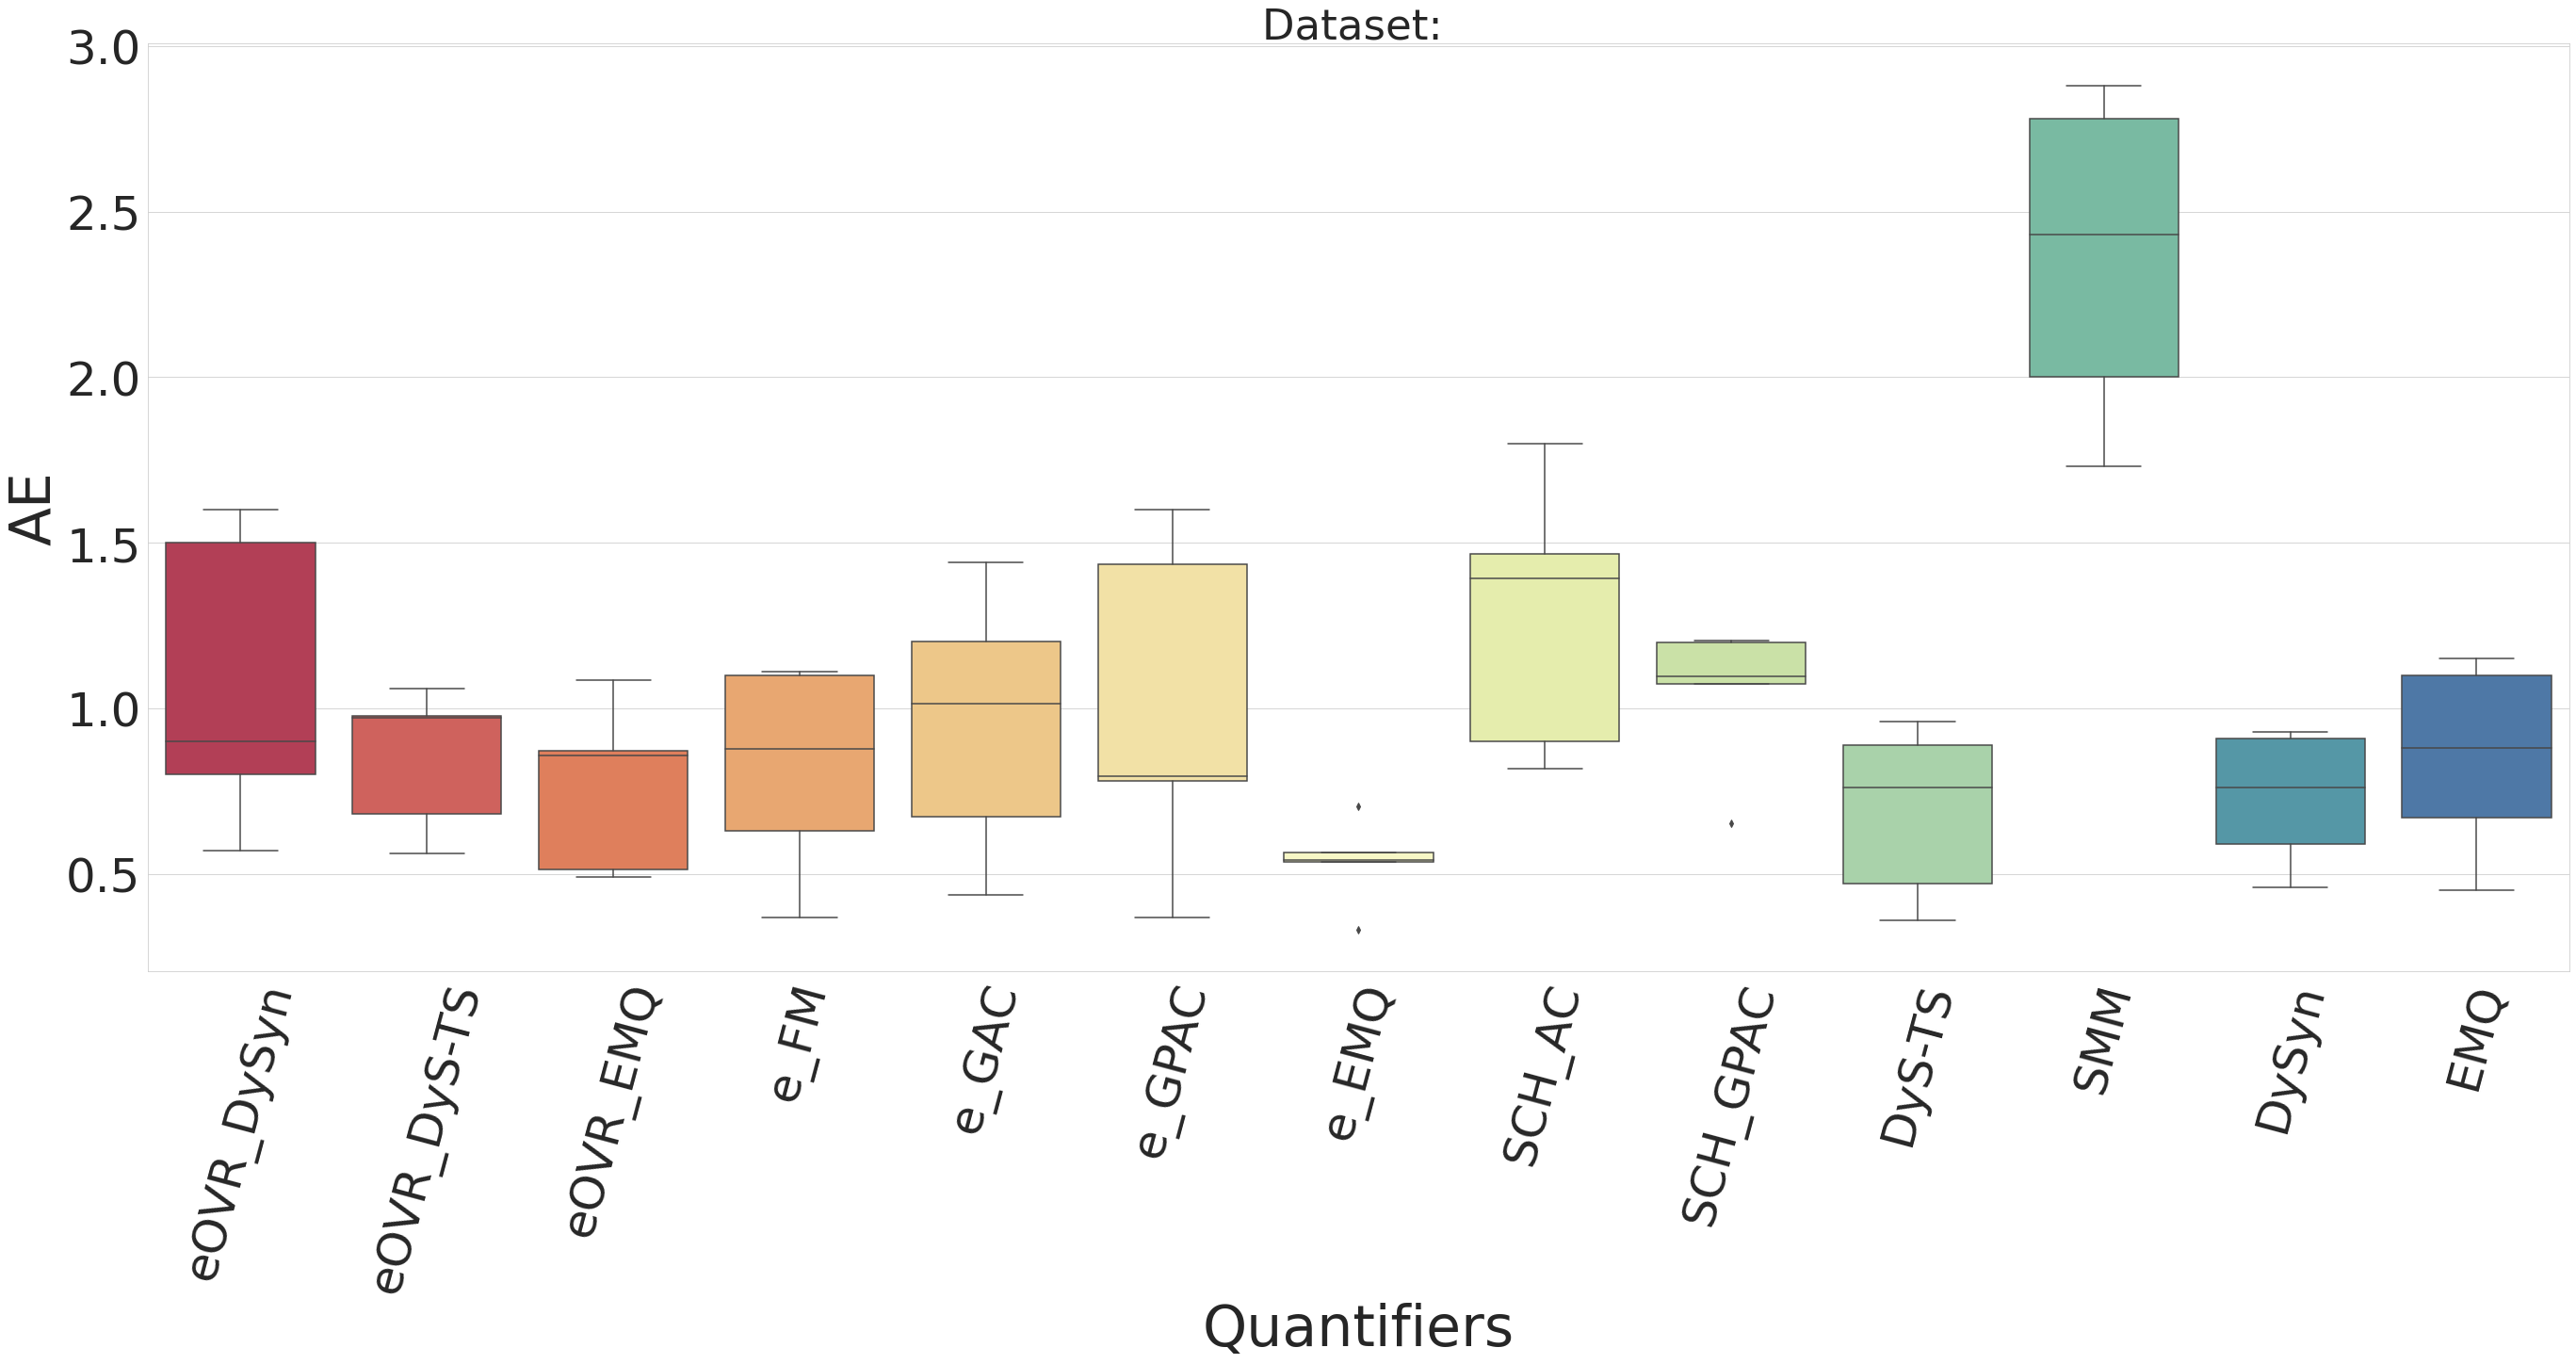

In [12]:
co_names = ['base',"setup","Test_size","error","quantifier", "dataset"]
result.columns = co_names  
plot_error_distribution(result[result['base'].isin(['XGB', 'ensemble', 'SCH'])], '')

In [12]:
dts = ["drugs",'wine',"video_game_sales", 'concrete', 'skillcraft', 'energy', 'news_popularity', 'nursery', 'turk_student_eval', 'yeast']
all_results = pd.DataFrame()

base_clf = 'RandomForestClassifier'
base_clf = 'SVC'
base_clf = 'XGBClassifier'


for dt in dts:
  print(dt)
  models = None
  if os.path.isfile('./models_scores/'+dt+'/'+base_clf+'_result.csv') is True:
    aux = pd.read_csv('./models_scores/'+dt+'/'+base_clf+'_result.csv')
    #aux2 = pd.read_csv('./models_scores/'+dt+'/resultv8.csv')
    #aux2 = aux2.drop(aux2[aux2.quantifier=='SCH_GPAC'].index)
    #aux = pd.concat([aux, aux2], axis=0)
    
    aux = aux[["Test_size","abs_error", "quantifier","dataset"]]    
    g = aux.groupby('quantifier')[['quantifier', 'abs_error', 'dataset']].mean().reset_index()

    rk = g.abs_error.rank()
    #g = g.drop(['abs_error'], axis=1)
    g['rank'] = rk
    all_results = pd.concat([all_results, g], axis=0)
    
    #re.to_csv('./models_scores/'+dt+"/result_new.csv")

    #plot_error_distribution(mo, dt)


drugs
wine
video_game_sales
concrete
skillcraft
energy
news_popularity
nursery
turk_student_eval
yeast


## Ranking

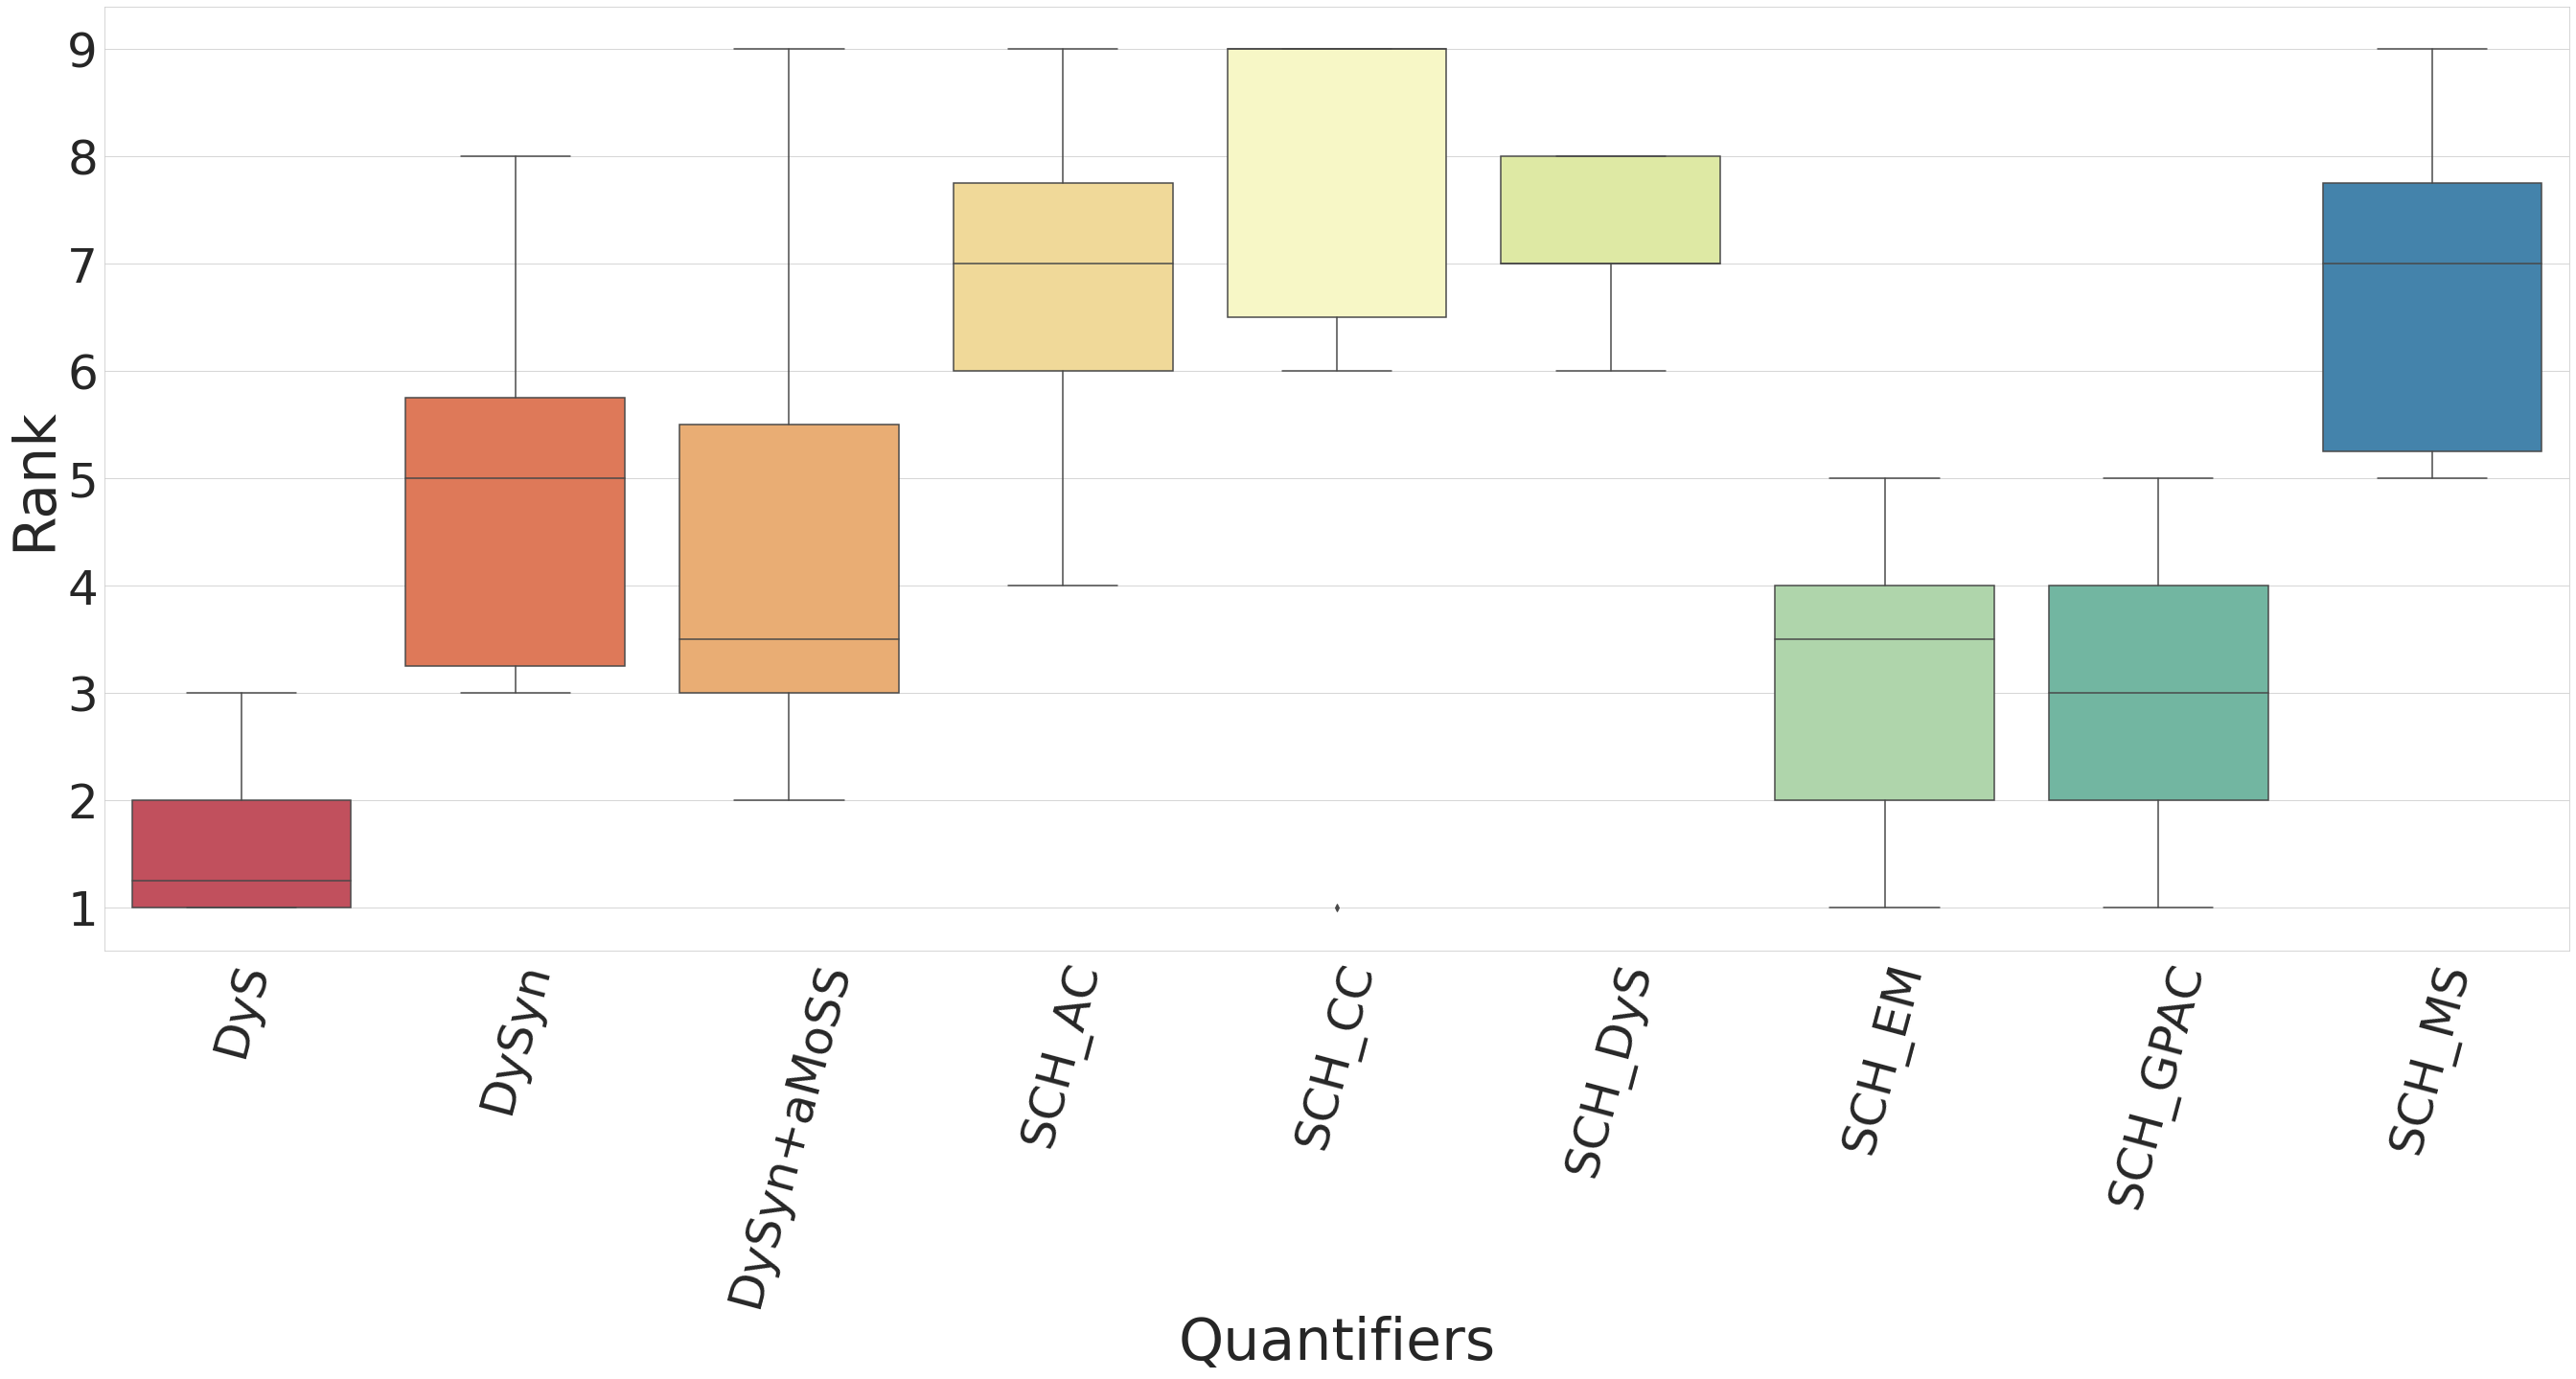

In [13]:
plot_rank(all_results, '')

## AE
The following plot shows the AE for a given dataset over all quantifiers tested.

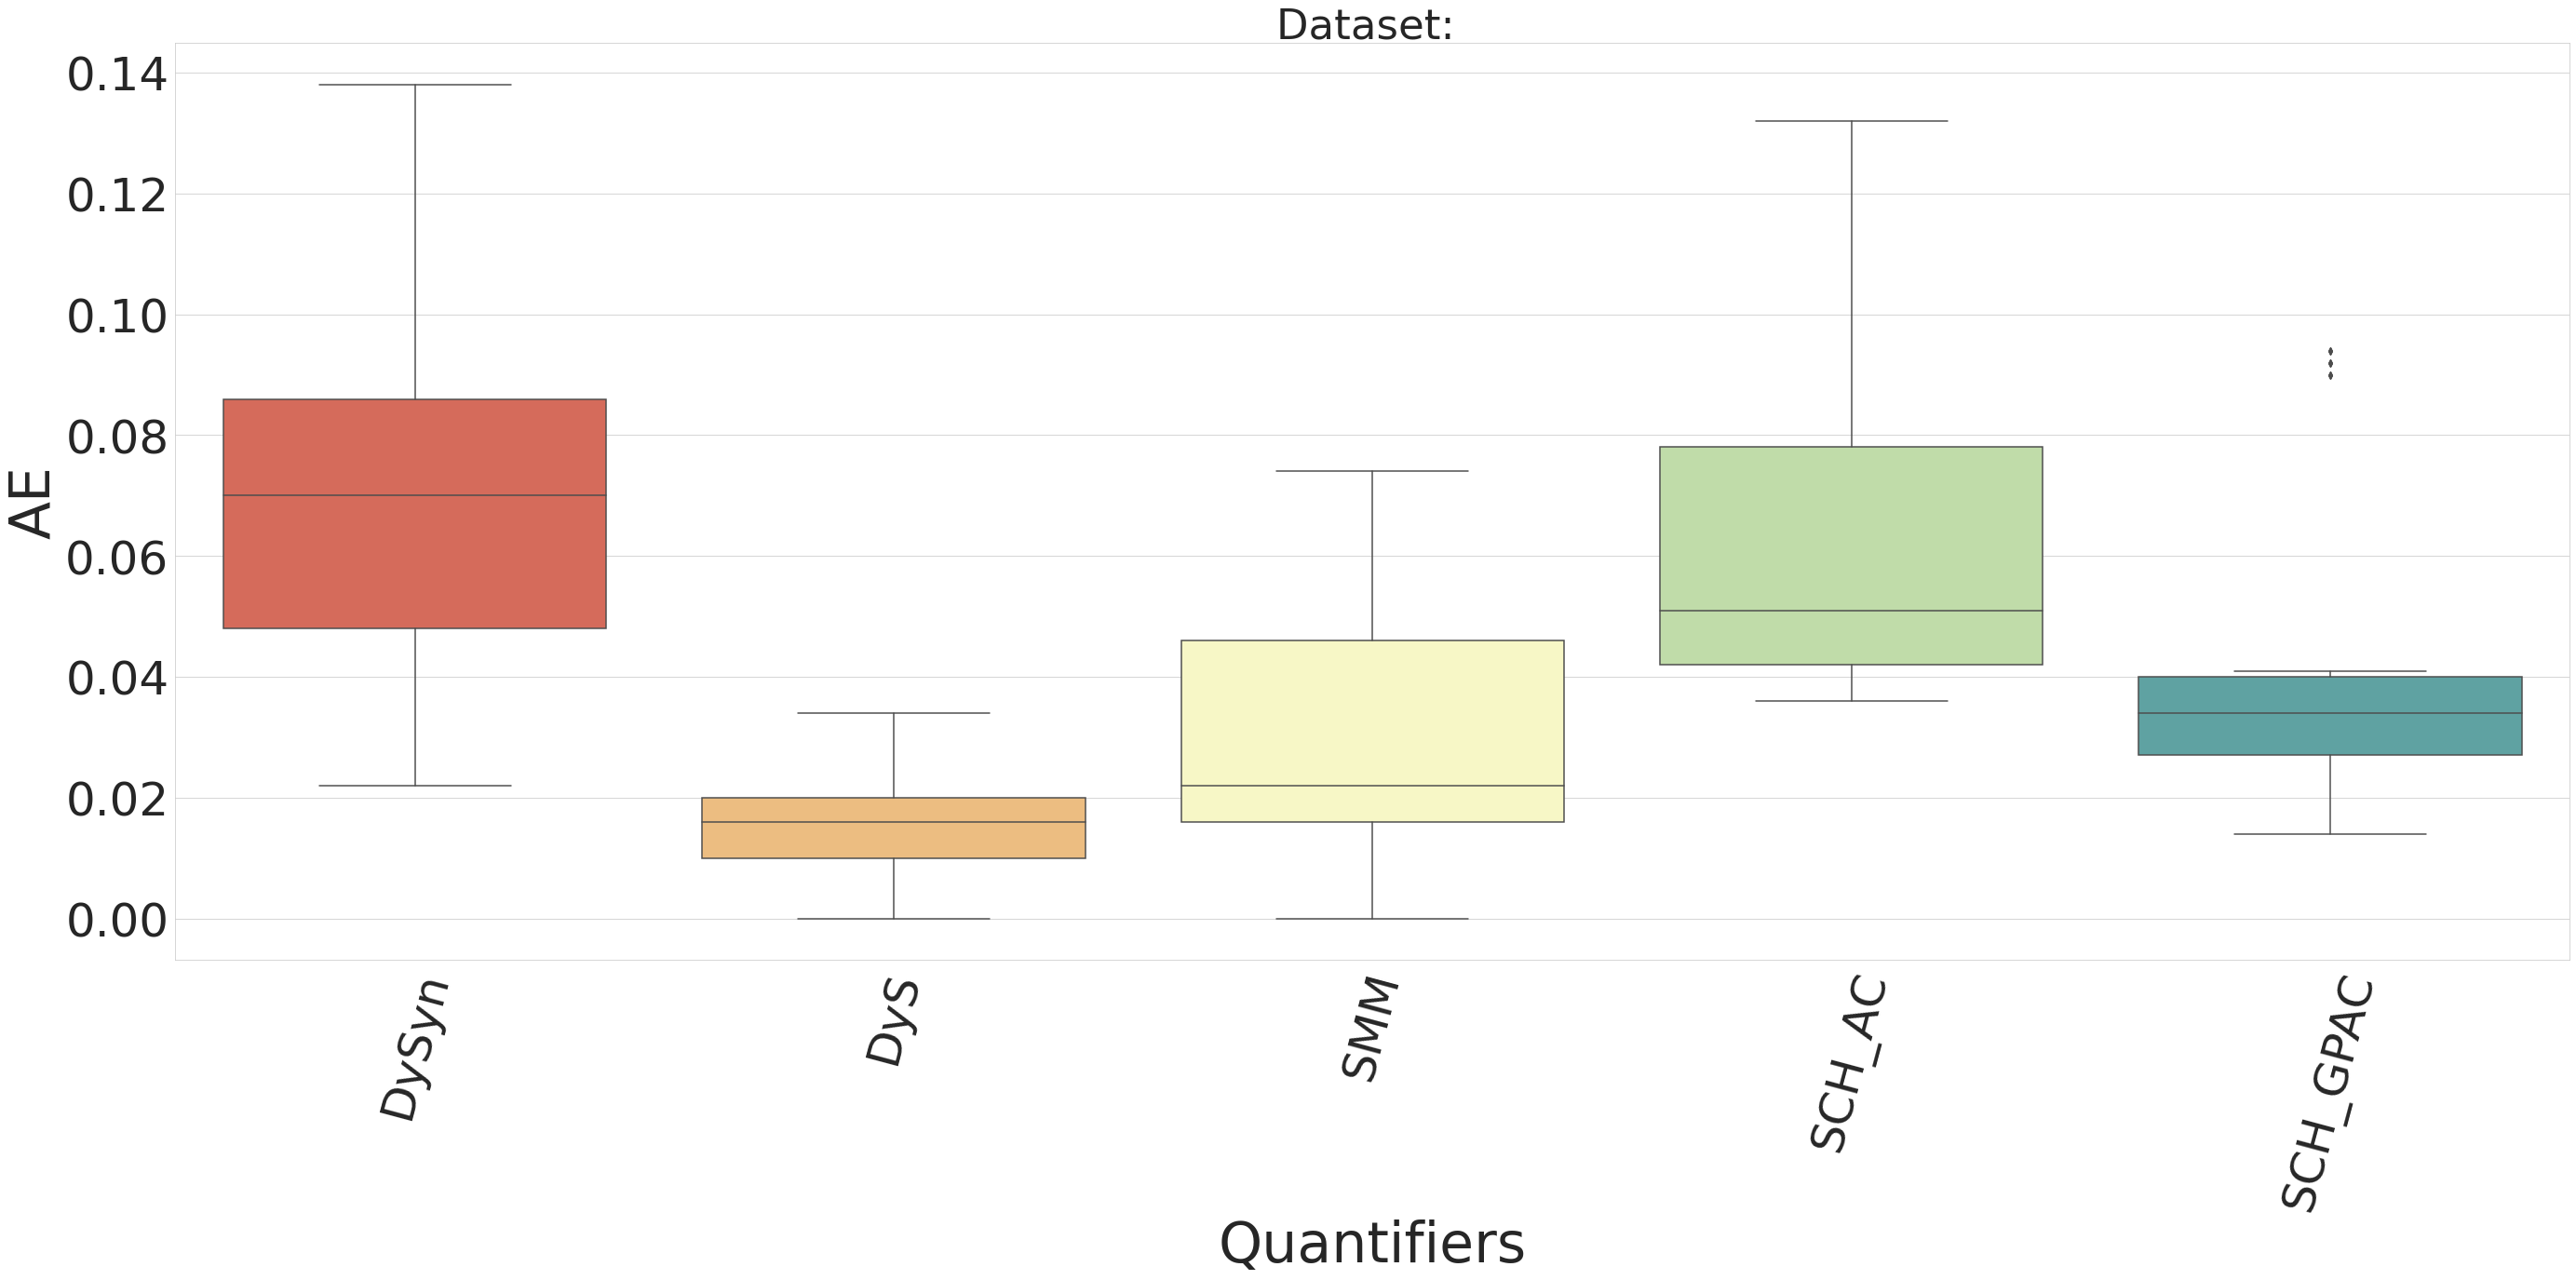

In [52]:
dataset = 'nursery' # It should be the same named of any subfolder of models_scores folder
base_clf = 'XGBClassifier'

re = pd.read_csv('./AAAI22/models_scores/'+dataset +'/'+base_clf+'_result.csv')
plot_error_distribution(re, '')